# Generative Adversarial Networks

Применение adversarial loss (более общей идеи, лежащей в основе GANов) позволило решить задачи, которые казались невозможными:

* [Машинный перевод без параллельных данных](https://arxiv.org/pdf/1710.11041.pdf)
* [Циклоганы: перевод изображений в другой домен](https://arxiv.org/abs/1703.10593)
* Колоризация и [Super Resolution](https://arxiv.org/abs/1807.02758)
* [Генерация и морфинг произвольных данных](https://arxiv.org/pdf/1809.11096.pdf) ([тут](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=HuCO9tv3IKT2) можно поиграться с генерацией бургеров)
* Применения в борьбе с adversarial атаками

Вот постоянно пополняющийся список приложений GANов: https://github.com/nashory/gans-awesome-applications

Сама [статья](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) Яна Гудфеллоу про GANы вышла в конце 2014 года и была процитирована 7687 раз за 4 года.


<img width='500px' src='https://cdn-images-1.medium.com/max/800/1*eWURQXT41pwHvDg1xDiEmw.png'>

Теперь немного формальных определений:

* Пусть $z$ — это вектор из латентного пространства, насэмпленный из нормального распределения.
* $G(z)$ обозначает функцию генератора, которая отображает латентный вектор в пространство данных. Цель $G$ — оценить истинное распределение данных $p_d$, чтобы сэмплировать данные из оцененного распределения $p_g$.
* $D(G(z))$ это вероятность (число от 0 до 1), что выход генератора $G$ является реальным изображением.

$D$ и $G$ играют в минимаксную игру, в которой $D$ старается максимизировать вероятность, что он правильно классифицирует реальные и сгенерированные сэмплы, а $G$ старается минимизировать эту вероятность:

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]$$

[Выясняется](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), что решение в этой минимаксной игре достигается при $p_g = p_d$ (и дискриминатор в этом случае может угадывать случайно). В реальности модели не всегда могут сойтись к этой точке.

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional GAN) называют GAN, который явно использует свёртки и транспонированные свёртки в дискриминаторе и генераторе соответственно. Откройте статью -- мы будем идти очень близко с авторами.

## Датасет
Всем надоели цифры, поэтому обучаться мы будем на датасете CelebA ([Large-scale CelebFaces Attributes](Large-scale CelebFaces Attributes)). В датасете на каждую фотку есть её аттрибуты, но мы их пока использовать не будем.

<img width='500px' src='http://mmlab.ie.cuhk.edu.hk/projects/celeba/overview.png'>

Автор, когда готовил эту тетрадку, долго думал, как загрузить датасет, чтобы всем было удобно. Это оказалось трудно, потому что прямых ссылок на него нигде нет, и, соответственно, просто сделать `!wget ...` нельзя. По удачному стечению обстоятельств, неделю назад кто-то [добавил](https://github.com/pytorch/vision/blob/master/torchvision/datasets/celeba.py) скрипты для загрузки этого датасета в сам `torchvision`, но в `pip` новая версия за такой срок ещё не успела появиться, поэтому мы обновимся напрямую из репозитория на гитхабе:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install git+https://github.com/pytorch/vision.git

  Cloning https://github.com/pytorch/vision.git to /tmp/pip-req-build-70i1ue2p
  Stored in directory: /tmp/pip-ephem-wheel-cache-fh8mz2ap/wheels/04/6d/bf/cc14a58bae32d07d1c7d23833dc5ea655e477ff25061b8cd57
Successfully built torchvision
fastai 1.0.51 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: torchvision 0.2.2.post3
    Uninstalling torchvision-0.2.2.post3:
      Successfully uninstalled torchvision-0.2.2.post3


In [0]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets

In [0]:
device = torch.device('cuda:0')  # не забудьте включить GPU

image_size = 64
batch_size = 64

In [0]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    # Normalize здесь приводит значения в промежуток [-1, 1]
])

dataset = datasets.CelebA('data', download=True, transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

1443490838it [00:11, 123704471.97it/s]
26721026it [00:01, 18199916.70it/s]
3424458it [00:00, 134644648.58it/s]
6082035it [00:00, 25693431.91it/s]
12156055it [00:00, 34696237.30it/s]
2836386it [00:00, 122924831.01it/s]


(64, 64, 3)


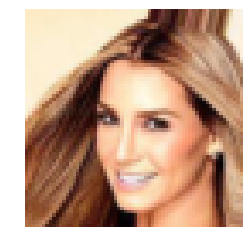

In [0]:
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
def draw(t):
    img = t.view((3, 64, 64)).transpose(0, 1).transpose(1, 2).cpu().numpy()
    print(img.shape)
    plt.axis('off')
    plt.imshow(img.reshape(64, 64, 3))
    plt.show()
draw(dataset[0][0])

## Модель

Генератор $G$ преобразует латентный вектор $z$ в пространство данных (в нашем случае -- картинки 3x64x64). В статье используют последовательность блоков из транспонированных свёрток, BatchNorm-ов и ReLU. На выходе каждое значение лежит в [-1, 1] (мы делаем TanH), в соответствии с нормализацией, которую мы сделали раньше.

<img width='600px' src='https://pytorch.org/tutorials/_images/dcgan_generator.png'>

In [0]:
num_channels = 3
latent_size = 100
base_size = 64

G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(latent_size, base_size * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.ReLU(True),
    nn.Dropout(0.1),
    # (base_size*8) x 4 x 4
    nn.ConvTranspose2d(base_size * 8, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.ReLU(True),
    nn.Dropout(0.1),
    # (base_size*4) x 8 x 8
    nn.ConvTranspose2d(base_size * 4, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.ReLU(True),
    nn.Dropout(0.1),
    # (base_size*2) x 16 x 16
    nn.ConvTranspose2d(base_size * 2, base_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.ReLU(True),
    nn.Dropout(0.1),
    # (base_size) x 32 x 32
    nn.ConvTranspose2d(base_size, num_channels, 4, 2, 1, bias=False),
    nn.BatchNorm2d(num_channels),
    nn.Sigmoid()
    # (num_channels) x 64 x 64
).to(device)

Дискриминатор -- это обычный бинарный классификатор. В статье он устроен симметрично генератору: Conv2d, BatchNorm, ReLU, Conv2d...

In [0]:
D = nn.Sequential(
    nn.Conv2d(num_channels, base_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.ReLU(True),
    nn.Dropout(0.1),
    nn.Conv2d(base_size, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.ReLU(True),
    nn.Dropout(0.1),
    nn.Conv2d(base_size * 2, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.ReLU(True),
    nn.Dropout(0.1),
    nn.Conv2d(base_size * 4, base_size * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.ReLU(True),
    nn.Dropout(0.1),
    nn.Conv2d(base_size * 8, 1, 4, 1, 0, bias=False),
    nn.BatchNorm2d(1),
    nn.Sigmoid()
).to(device)

In [0]:

z = torch.randn(1, latent_size, 1, 1).to(device)
G(z)

tensor([[[[0.4752, 0.5279, 0.3715,  ..., 0.4454, 0.4566, 0.4546],
          [0.5035, 0.3094, 0.3975,  ..., 0.4094, 0.5075, 0.5097],
          [0.4576, 0.4178, 0.5445,  ..., 0.3919, 0.4033, 0.4942],
          ...,
          [0.5059, 0.4214, 0.4539,  ..., 0.4291, 0.5816, 0.4188],
          [0.4952, 0.3356, 0.5566,  ..., 0.4578, 0.6436, 0.4551],
          [0.5005, 0.4821, 0.5331,  ..., 0.4663, 0.5602, 0.5255]],

         [[0.4552, 0.5527, 0.4007,  ..., 0.5124, 0.5108, 0.4912],
          [0.5472, 0.4770, 0.4420,  ..., 0.5133, 0.3894, 0.5394],
          [0.4670, 0.3594, 0.5187,  ..., 0.6154, 0.4482, 0.5653],
          ...,
          [0.4865, 0.5418, 0.6135,  ..., 0.6129, 0.5039, 0.5093],
          [0.4244, 0.4084, 0.2815,  ..., 0.5139, 0.4774, 0.4917],
          [0.4891, 0.5752, 0.5080,  ..., 0.4874, 0.5276, 0.4593]],

         [[0.6447, 0.6696, 0.5836,  ..., 0.6342, 0.6355, 0.6169],
          [0.5852, 0.4437, 0.5188,  ..., 0.7718, 0.7578, 0.6244],
          [0.5924, 0.5615, 0.7516,  ..., 0

В статье акцентируют внимание на необходимость нестандартной инициализации весов.

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# apply рекурсивно применяет применяет функцию ко всем своим подмодулям
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Dropout(p=0.1)
  (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace)
  (7): Dropout(p=0.1)
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace)
  (11): Dropout(p=0.1)
  (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace)
  (15): Dropout(p=0.1)
  (16): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (17): BatchNorm2d(1, eps=1e-05, momentum=0.

## Обучение

У GANов, помимо сходимости, есть проблема, что их непонятно, как сравнивать между собой, потому что у нас не один лосс, а два. Поэтому полезнее во время обучения смотреть на генерируемые картинки, а не цифры.

In [0]:
from IPython.display import clear_output
def draw_my_picture():
    z = torch.randn(batch_size * 2, latent_size, 1, 1).to(device)
    img = G(z).data[0]
    img = img.view((3, 64, 64)).transpose(0, 1).transpose(1, 2).cpu().numpy()
    plt.axis('off')
    plt.imshow(img.reshape(64, 64, 3))
    plt.show()


In [0]:
D.load_state_dict(torch.load('/content/drive/My Drive/D.pt'))
G.load_state_dict(torch.load('/content/drive/My Drive/G.pt'))

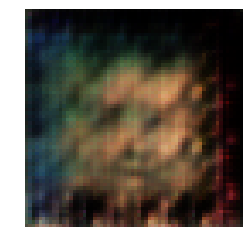

0.0003165296511724591 11.717899322509766
0


KeyboardInterrupt: ignored

In [0]:
num_epochs = 1000
learning_rate = 1e-3

G_losses = []
D_losses = []
iters = 0

optim_G = torch.optim.Adam(G.parameters(), lr=learning_rate) # ваш любимый оптимизатор параметров дискриминатора
optim_D = torch.optim.Adam(D.parameters(), lr=learning_rate) # ваш любимый оптимизатор параметров генератора
criterion_G = nn.BCELoss()
criterion_D = nn.BCELoss()
for epoch in range(num_epochs):
    for (data, _) in loader:
        if data.shape[0] != batch_size:
            break
        # Обучать GANы всегда долго, и мы хотим по максимуму переиспользовать вычисления

        # 1. Обучим D: max log(D(x)) + log(1 - D(G(z)))
        
        D.zero_grad()
        G.zero_grad()
        D.train()
        G.eval()
        z = torch.randn(batch_size, latent_size, 1, 1).to(device)
        another_data = G(z)
        data = data.to(device)
#         if iters % 100 == 0:
#             draw(data[0])
#             draw(another_data[0].detach())
        another_data = torch.cat([data, another_data]).to(device)
        y = torch.cat([torch.ones(batch_size), torch.zeros(batch_size)]).to(device)
        y_pred = D(another_data)
        D_loss = criterion_D(y_pred, y.reshape((2 * batch_size, 1, 1, 1)))
        D_loss.backward()
        optim_D.step()
#         if iters % 100 == 0:
#             print(y_pred.reshape(batch_size * 2))
        G.zero_grad()
        D.zero_grad()
        G.train()
        D.eval()
        z = torch.randn(2 * batch_size, latent_size, 1, 1).to(device)
#         z = torch.cat([z, z]).to(device)
        another_data = G(z)
        y_pred = D(another_data)
#         if iters % 100 == 0:
#               draw(another_data[0].detach())
#               print(y_pred.reshape(batch_size * 2))
        G_loss = criterion_G(y_pred, torch.ones(2 * batch_size).to(device).reshape((2 * batch_size, 1, 1, 1)))
        G_loss.backward()
#         print(G_loss.item())
        # Тут проще:
        #    Получим вектор неправильных ответов -- вектор единиц (мы ведь хотим, чтобы D считал их неправильными)
        #    Прогоним ранее сгенерированные картинки через D
        #    Посчитаем лосc, сделаем .backward()
        
        optim_G.step()
        # Раз в сколько-то итераций логгируем лосс
#         break
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        if iters % 100 == 0:
            D.eval()
            G.eval()
            clear_output()
            draw_my_picture()        
            print(D_loss.item(), G_loss.item())
            print(epoch)
            torch.save(D.state_dict(), '/content/drive/My Drive/D.pt')
            torch.save(G.state_dict(), '/content/drive/My Drive/G.pt')
        iters += 1


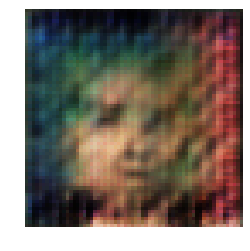

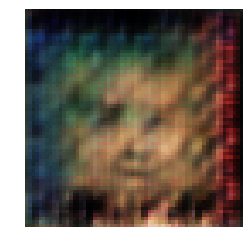

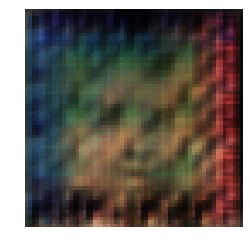

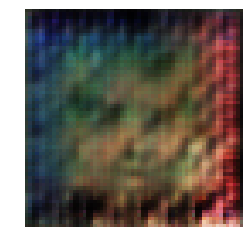

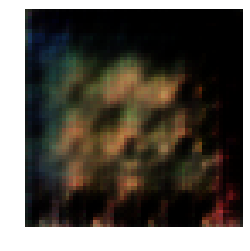

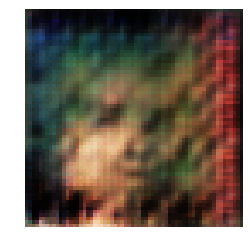

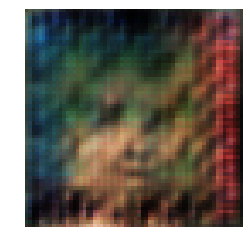

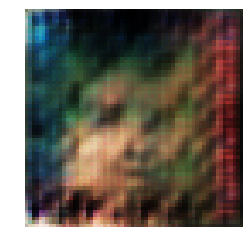

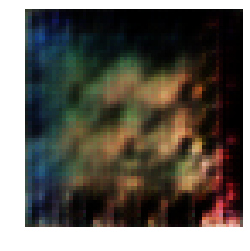

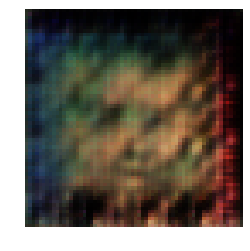

In [0]:
D.eval()
G.eval()
for i in range(10):
  draw_my_picture()

### Что дальше?

Довольно старый, но актуальный список трюков: https://github.com/soumith/ganhacks

Вообще, теория сходимости GANов очень сильно развилась за последнее время. Если хотите во всём этом разобраться, то возьмите какую-нибудь [достаточно новую статью](https://arxiv.org/pdf/1802.05957.pdf) и рекурсивно почитайте оттуда абстракты из списока литературы.